In [4]:
#Importing Libraries

import tensorflow as tf 
import numpy as np
import os
import sys
import random
import cv2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,concatenate
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Conv2DTranspose,ZeroPadding2D,AveragePooling2D,Dense,InputLayer,Flatten,Lambda
from tensorflow.keras.layers import BatchNormalization,Concatenate

## **Preparing the data**

In [ ]:
#Extracting dataset file 
import zipfile

local_zip = '/content/drive/MyDrive/Face Detection/trainset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/drive/MyDrive/Face Detection/')
zip_ref.close()

### **Defining the path of dataset and haar cascade**

In [1]:
PATH = '/content/drive/MyDrive/Face Detection/trainset'
path_haar='/content/drive/MyDrive/Face Detection/haarcascade_frontalface_default.xml'

In [2]:
reference_images=[]
selfies=[]
n_sub=0

In [5]:
for folder in os.listdir(PATH):
    subfolder=os.path.join(PATH,folder)
    for sub in os.listdir(subfolder):
        n_sub=n_sub+1
        img_dir=os.path.join(subfolder,sub)
        for img_raw in os.listdir(img_dir):
            if 'script' in img_raw:
                reference_images.append(img_raw)
            else :
                selfies.append(img_raw)

In [6]:
print("The total number of Folders in dataset : ",len(os.listdir(PATH)))
print("The total number of Employee in dataset : ",n_sub)
print("The total number of selfies are : ",len(selfies))
print("The total number of script images are : ",len(reference_images))

The total number of Folders in dataset :  12
The total number of Employee in dataset :  1012
The total number of selfies are :  3198
The total number of script images are :  1221


#**Building network**


In [7]:
def block_1a(X):
       
    X_3=tf.keras.layers.Conv2D(96,(1,1),data_format='channels_first',activation='relu',name='Block_1a_First_Layer')(X)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    X_3=tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=tf.keras.layers.Conv2D(128,(3,3),data_format='channels_first',activation='relu')(X_3)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    
    X_5=tf.keras.layers.Conv2D(16,(1,1),data_format='channels_first',activation='relu')(X)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    X_5=tf.keras.layers.ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=tf.keras.layers.Conv2D(32,(5,5),data_format='channels_first',activation='relu')(X_5)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    
    X_pool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = tf.keras.layers.Conv2D(32,(1,1),data_format='channels_first',activation='relu')(X_pool)
    X_pool = tf.keras.layers.BatchNormalization(axis=1, epsilon=0.00001)(X_pool)
    X_pool = tf.keras.layers.ZeroPadding2D(padding=((3, 4), (3, 4)), data_format='channels_first')(X_pool)
    
    X_1=tf.keras.layers.Conv2D(64,(1,1),data_format='channels_first',activation='relu')(X)
    X_1=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_1)
    
    inception=tf.keras.layers.concatenate([X_3,X_5,X_pool,X_1],axis=1)
    return inception
    

def block_1b(X):
    X_3=tf.keras.layers.Conv2D(96,(1,1),data_format='channels_first',activation='relu',name='Block_1b_First_Layer')(X)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    X_3=tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=tf.keras.layers.Conv2D(128,(3,3),data_format='channels_first',activation='relu')(X_3)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    
    X_5=tf.keras.layers.Conv2D(32,(1,1),data_format='channels_first',activation='relu')(X)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    X_5=tf.keras.layers.ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=tf.keras.layers.Conv2D(64,(5,5),data_format='channels_first',activation='relu')(X_5)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    
    X_poolAvg = tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(3,3), data_format='channels_first')(X)
    X_poolAvg = tf.keras.layers.Conv2D(64,(1,1),data_format='channels_first',activation='relu')(X_poolAvg)
    X_poolAvg = tf.keras.layers.BatchNormalization(axis=1, epsilon=0.00001)(X_poolAvg)
    X_poolAvg = tf.keras.layers.ZeroPadding2D(padding=(4,4), data_format='channels_first')(X_poolAvg)
    
    X_1=tf.keras.layers.Conv2D(64,(1,1),data_format='channels_first',activation='relu')(X)
    X_1=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_1)
    
    inception=concatenate([X_3,X_5,X_poolAvg,X_1],axis=1)
    return inception

def block_1c(X):
    X_3=tf.keras.layers.Conv2D(128,(1,1),data_format='channels_first',activation='relu', name='Block_1c_First_Layer')(X)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    X_3=tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=tf.keras.layers.Conv2D(256,(3,3),strides=(2,2),data_format='channels_first',activation='relu')(X_3)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    
    X_5=tf.keras.layers.Conv2D(32,(1,1),data_format='channels_first',activation='relu')(X)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    X_5=tf.keras.layers.ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=tf.keras.layers.Conv2D(64,(5,5),strides=(2,2),data_format='channels_first',activation='relu')(X_5)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    
    X_poolAvg = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_poolAvg = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)), data_format='channels_first')(X_poolAvg)
      
    inception=concatenate([X_3,X_5,X_poolAvg],axis=1)
    return inception


def block_2a(X):
    X_3=tf.keras.layers.Conv2D(96,(1,1),data_format='channels_first',activation='relu',name='Block_2a_First_Layer')(X)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    X_3=tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=tf.keras.layers.Conv2D(192,(3,3),data_format='channels_first',activation='relu')(X_3)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    
    X_5=tf.keras.layers.Conv2D(32,(1,1),data_format='channels_first',activation='relu')(X)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    X_5=tf.keras.layers.ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=tf.keras.layers.Conv2D(64,(5,5),data_format='channels_first',activation='relu')(X_5)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    
    X_poolAvg = tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(3,3), data_format='channels_first')(X)
    X_poolAvg = tf.keras.layers.Conv2D(128,(1,1),data_format='channels_first',activation='relu')(X_poolAvg)
    X_poolAvg = tf.keras.layers.BatchNormalization(axis=1, epsilon=0.00001)(X_poolAvg)
    X_poolAvg = tf.keras.layers.ZeroPadding2D(padding=(2,2), data_format='channels_first')(X_poolAvg)
    
    
    X_1=tf.keras.layers.Conv2D(256,(1,1),data_format='channels_first',activation='relu')(X)
    X_1=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_1)
    
    inception=concatenate([X_3,X_5,X_poolAvg,X_1],axis=1)
    return inception


def block_2b(X):
    X_3=tf.keras.layers.Conv2D(160,(1,1),data_format='channels_first',activation='relu',name='Block_2b_First_Layer')(X)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    X_3=tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=tf.keras.layers.Conv2D(256,(3,3),strides=(2,2),data_format='channels_first',activation='relu')(X_3)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    
    X_5=tf.keras.layers.Conv2D(64,(1,1),data_format='channels_first',activation='relu')(X)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    X_5=tf.keras.layers.ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5)
    X_5=tf.keras.layers.Conv2D(128,(5,5),strides=(2,2),data_format='channels_first',activation='relu')(X_5)
    X_5=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_5)
    
    X_pool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = tf.keras.layers.ZeroPadding2D(padding=((0,1),(0,1)),data_format='channels_first')(X_pool)
    
    inception=concatenate([X_3,X_5,X_pool],axis=1)
    return inception     


def block_3a(X):
    X_3=tf.keras.layers.Conv2D(96,(1,1),data_format='channels_first',activation='relu',name='Block_3a_First_Layer')(X)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    X_3=tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=tf.keras.layers.Conv2D(384,(3,3),data_format='channels_first',activation='relu')(X_3)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
       
    X_pool = tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(3,3), data_format='channels_first')(X)
    X_pool = tf.keras.layers.Conv2D(96,(1,1),data_format='channels_first',activation='relu')(X_pool)
    X_pool = tf.keras.layers.BatchNormalization(axis=1, epsilon=0.00001)(X_pool)
    X_pool = tf.keras.layers.ZeroPadding2D(padding=(1,1), data_format='channels_first')(X_pool)
    
    
    X_1=tf.keras.layers.Conv2D(256,(1,1),data_format='channels_first',activation='relu')(X)
    X_1=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_1)
    
    inception=concatenate([X_3,X_pool,X_1],axis=1)
    return inception


def block_3b(X):
    X_3=tf.keras.layers.Conv2D(96,(1,1),data_format='channels_first',activation='relu',name='Block_3b_First_Layer')(X)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    X_3=tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3)
    X_3=tf.keras.layers.Conv2D(384,(3,3),data_format='channels_first',activation='relu')(X_3)
    X_3=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_3)
    
    X_pool = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=2, data_format='channels_first')(X)
    X_pool = tf.keras.layers.Conv2D(96,(1,1),data_format='channels_first',activation='relu')(X_pool)
    X_pool = tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_pool)
    X_pool = tf.keras.layers.ZeroPadding2D((1,1),data_format='channels_first')(X_pool)
    
    X_1=tf.keras.layers.Conv2D(256,(1,1),data_format='channels_first',activation='relu')(X)
    X_1=tf.keras.layers.BatchNormalization(axis=1,epsilon=0.00001)(X_1)
    
    inception=concatenate([X_3,X_pool,X_1],axis=1)
    return inception



def FinalModel(input_shape):
    
    X_input=tf.keras.layers.Input(input_shape)
        
    X = tf.keras.layers.ZeroPadding2D(padding=(3,3),data_format='channels_first')(X_input)
    
    X = tf.keras.layers.Conv2D(64,(7,7),strides=(2,2),activation='relu',data_format='channels_first',name='convolution_1')(X)
    X = tf.keras.layers.BatchNormalization(axis=1)(X)
    X = tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X)
    X = tf.keras.layers.MaxPooling2D((3,3),strides=2,data_format='channels_first')(X)
    
    X = tf.keras.layers.Conv2D(64,(1,1),strides=(1,1),activation='relu',data_format='channels_first',name='convolution_2')(X)
    X = tf.keras.layers.BatchNormalization(axis=1)(X)
    X = tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X)
    
    X = tf.keras.layers.Conv2D(192,(3,3),strides=(1,1),activation='relu',data_format='channels_first',name='convolution_3')(X)
    X = tf.keras.layers.BatchNormalization(axis=1)(X)    
    X = tf.keras.layers.ZeroPadding2D(padding=(1,1),data_format='channels_first')(X)
    X = tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),data_format='channels_first')(X)
    
        
    X = block_1a(X)
    X = block_1b(X)
    X = block_1c(X)
    
    X = block_2a(X)
    X = block_2b(X)
    
    X = block_3a(X)
    X = block_3b(X)
    
    X = tf.keras.layers.AveragePooling2D(pool_size=(3,3), strides=(1,1), data_format='channels_first')(X)
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(128,activation='relu',kernel_initializer='glorot_normal')(X)
    X = tf.keras.layers.Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_1')(X)
    
    model=Model(inputs=X_input,outputs=X,name='FaceRecognotionModel')
    return model 

In [8]:
model=FinalModel(input_shape=(3,96,96))
model.summary()

Model: "FaceRecognotionModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 3, 102, 102)  0           input_1[0][0]                    
__________________________________________________________________________________________________
convolution_1 (Conv2D)          (None, 64, 48, 48)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 48, 48)   256         convolution_1[0][0]              
_______________________________________________________________________________

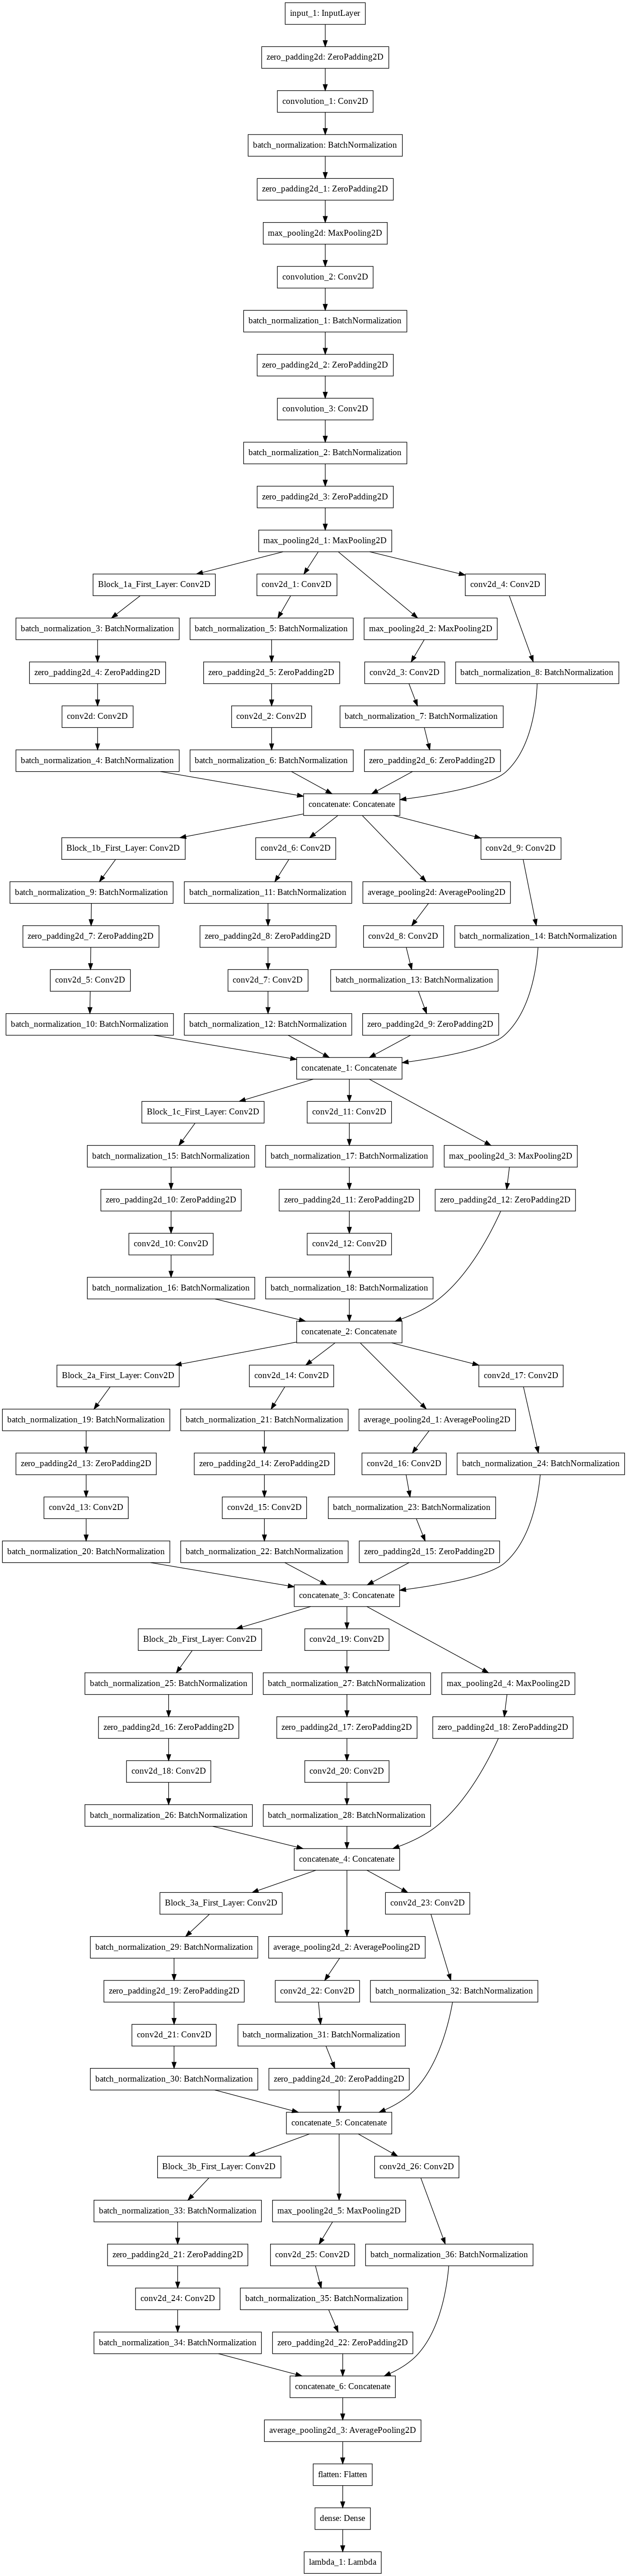

In [9]:
plot_model(model,to_file='Model.png')

## **Defining the Triplet Loss Function**

In [10]:
def triplet_loss_t(y_true,y_pred):
    anchor=y_pred[:,0:128]
    pos=y_pred[:,128:256]
    neg=y_pred[:,256:384]
    
    positive_distance = K.sum(K.abs(anchor-pos), axis=1)
    negative_distance = K.sum(K.abs(anchor-neg), axis=1)
    probs=K.softmax([positive_distance,negative_distance],axis=0)
    loss=K.mean(K.abs(probs[0])+K.abs(1.0-probs[1]))
    return loss



### Function to resize the image to match the input shape of the model

In [11]:
def localize_resize(path_image,path_haar='F:/Datasets/haarcascade_frontalface_default.xml'):
    image=cv2.imread(path_image)
    
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=cv2.CascadeClassifier(path_haar)
    faces=classifier.detectMultiScale(gray,1.1,6)
    if len(faces) != 1:#condition if we dont have any faces or cant be detected y haar cascade we will skip those
        return -1
    
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(96,96))
    image=np.transpose(image,(2,0,1))
    image=image.astype('float32')/255.0
    return image

## **Defining the generator**

In [12]:
def data_gen(batch_size=32):
    while True:
        i=0
        positive=[]
        anchor=[]
        negative=[]    
        

        while(i<batch_size):
            r=random.choice(os.listdir(PATH))
            p=PATH+'/'+ r
            id=os.listdir(p)
            ra=random.sample(id,2)
            pos_dir=p+'/'+ra[0]
            neg_dir=p+'/'+ra[1]
            pos=pos_dir+'/'+random.choice(os.listdir(pos_dir))
            anc=pos_dir+'/'+random.choice([x for x in os.listdir(pos_dir) if 'script' in x])
            neg=neg_dir+'/'+random.choice(os.listdir(neg_dir))
            pos_img=localize_resize(pos,path_haar)
                    
            if pos_img is -1:
                continue
            neg_img=localize_resize(neg,path_haar)
            if neg_img is -1:
                continue
            anc_img=localize_resize(anc,path_haar)
            if anc_img is -1:
                continue
            positive.append(list(pos_img))
            negative.append(list(neg_img))
            anchor.append(list(anc_img))
            i=i+1
        
        yield ([np.array(anchor),np.array(positive),np.array(negative)],np.zeros((batch_size,1)).astype("float32"))

## **Defining model for triplet loss**

In [13]:
triplet_model_a=Input((3,96,96))
triplet_model_n=Input((3,96,96))
triplet_model_p=Input((3,96,96))
triplet_model_out=Concatenate()([model(triplet_model_a),model(triplet_model_p),model(triplet_model_n)])
triplet_model=Model([triplet_model_a,triplet_model_p,triplet_model_n],triplet_model_out)

In [14]:
triplet_model.compile(optimizer='adam',loss=triplet_loss_t)
triplet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 3, 96, 96)]  0                                            
__________________________________________________________________________________________________
FaceRecognotionModel (Functiona (None, 128)          3743280     input_2[0][0]                    
                                                                 input_4[0][0]                

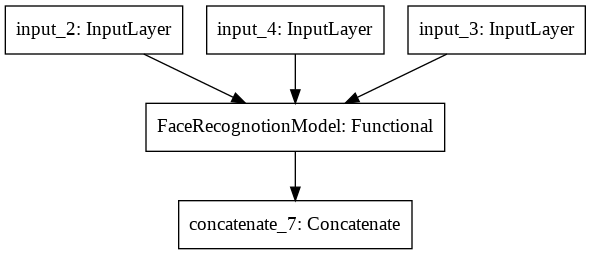

In [15]:
plot_model(triplet_model)

## **Training the model**


> Training the model for 10 epoch and with steps_per_epoch as 100  block



> Since batch size is 32 and total number of samples is almost 3200 so steps_per_epoch=100





In [16]:
triplet_model.fit(data_gen(),steps_per_epoch=100,epochs=10)

Epoch 1/10
100/100 [==============================] - 3206s 32s/step - loss: 0.5343
Epoch 2/10
100/100 [==============================] - 2492s 25s/step - loss: 0.4509
Epoch 3/10
100/100 [==============================] - 2320s 23s/step - loss: 0.3979
Epoch 4/10
100/100 [==============================] - 2126s 21s/step - loss: 0.3980
Epoch 5/10
100/100 [==============================] - 2312s 23s/step - loss: 0.3549
Epoch 6/10
100/100 [==============================] - 2060s 21s/step - loss: 0.3313
Epoch 7/10
100/100 [==============================] - 2209s 22s/step - loss: 0.3200
Epoch 8/10
100/100 [==============================] - 2051s 21s/step - loss: 0.2984
Epoch 9/10
100/100 [==============================] - 2127s 21s/step - loss: 0.2805
Epoch 10/10
100/100 [==============================] - 2117s 21s/step - loss: 0.2348


## **Saving the model**

In [17]:
triplet_model.save('FaceRecognition_model.h5')

# **Implementation of the model**



> **Function to preprocess the image according to the model requirements**





In [18]:
##To loacaloze the face and resize the image

def image_resizing(image,path_haar):

    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=cv2.CascadeClassifier(path_haar)
    faces=classifier.detectMultiScale(gray,1.1,6)

    if len(faces)!=1:
        print('More than one Image in the selfie')
        sys.exit(0)
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(96,96))

    return image

In [19]:
def encode_img(img1,triplet_model):
    img=img1[...,::-1]
    img=np.around(np.transpose(img,(2,0,1))/255,decimals=12)
    x_train=np.array([img])
    emb=triplet_model.layers[3].predict_on_batch(x_train)
    return emb

In [20]:
threshold=0.65
interval=0.3
def confidence_value(ref_encode,img_encode,thres=threshold):
    dist=np.linalg.norm((img_encode-ref_encode))
    confidence=(threshold-max([dist,interval]))/(threshold-interval)
    return dist,confidence

## **Checking with same person**

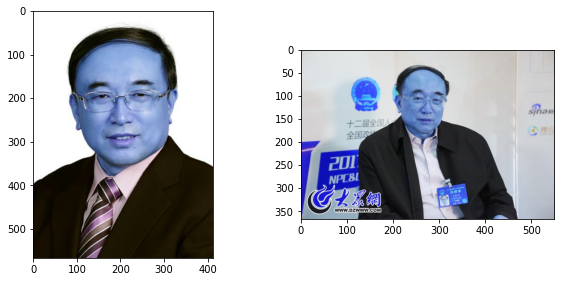

In [44]:
rimage=cv2.imread('/content/drive/MyDrive/Face Detection/trainset/0007/0007_0000658/0007_0000658_script.jpg')
image=cv2.imread('/content/drive/MyDrive/Face Detection/trainset/0007/0007_0000658/0000001.jpg')

fig=plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rimage)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(image)

In [45]:
rimage=cv2.imread('/content/drive/MyDrive/Face Detection/trainset/0007/0007_0000658/0007_0000658_script.jpg')
image=cv2.imread('/content/drive/MyDrive/Face Detection/trainset/0007/0007_0000658/0000001.jpg')

rimg=image_resizing(rimage,path_haar)
img=image_resizing(image,path_haar)
r_encode=encode_img(rimg,triplet_model)
img_encode=encode_img(img,triplet_model)
dist,conf=confidence_value(r_encode,img_encode)
if dist<threshold:
    print("Match with a confidence of ",conf*100)
    #print("Distance ",dist)
else:
    print("No Match with a confidence of ",abs(conf*100))

Match with a confidence of  14.7148609161377


## **Checking with Different person**

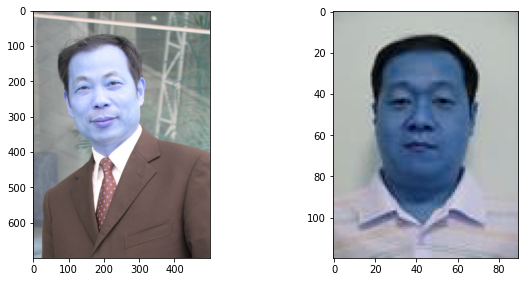

In [36]:
rimage=cv2.imread('/content/drive/MyDrive/Face Detection/trainset/0007/0007_0000646/0000000.jpg')
image=cv2.imread('/content/drive/MyDrive/Face Detection/trainset/0008/0008_0001449/0008_0001449_script.jpg')
fig=plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rimage)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(image)

In [37]:
rimage=cv2.imread('/content/drive/MyDrive/Face Detection/trainset/0007/0007_0000646/0000000.jpg')
image=cv2.imread('/content/drive/MyDrive/Face Detection/trainset/0008/0008_0001449/0008_0001449_script.jpg')
rimg=image_resizing(rimage,path_haar)
img=image_resizing(image,path_haar)
r_encode=encode_img(rimg,triplet_model)
img_encode=encode_img(img,triplet_model)
dist,conf=confidence_value(r_encode,img_encode)
if dist<threshold:
    print("Match with a confidence of ",conf*100)
else:
    print("No Match with a confidence of ",abs(conf*100))

No Match with a confidence of  16.464567184448235
